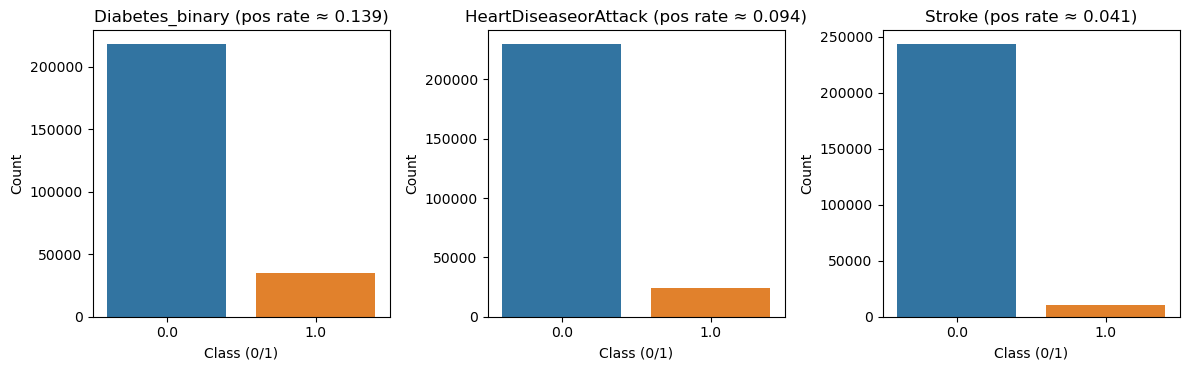

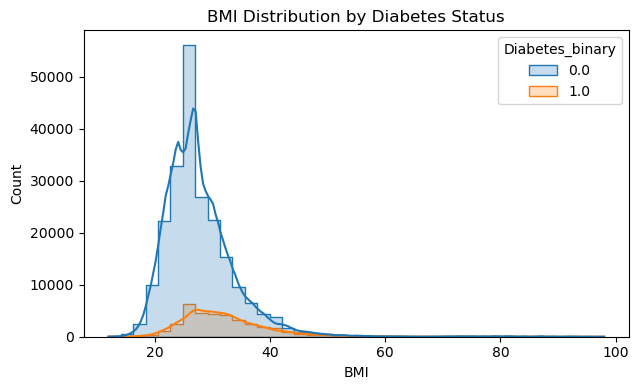

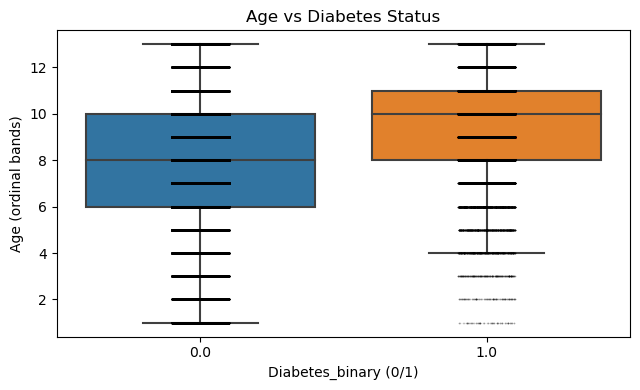

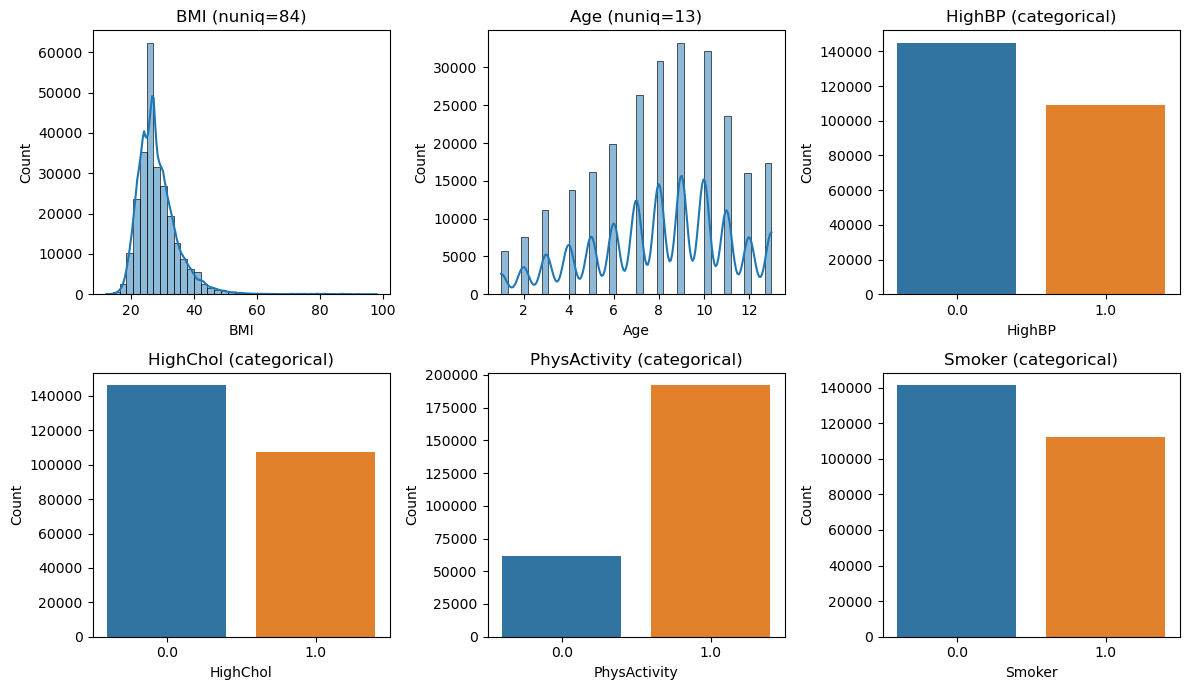

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


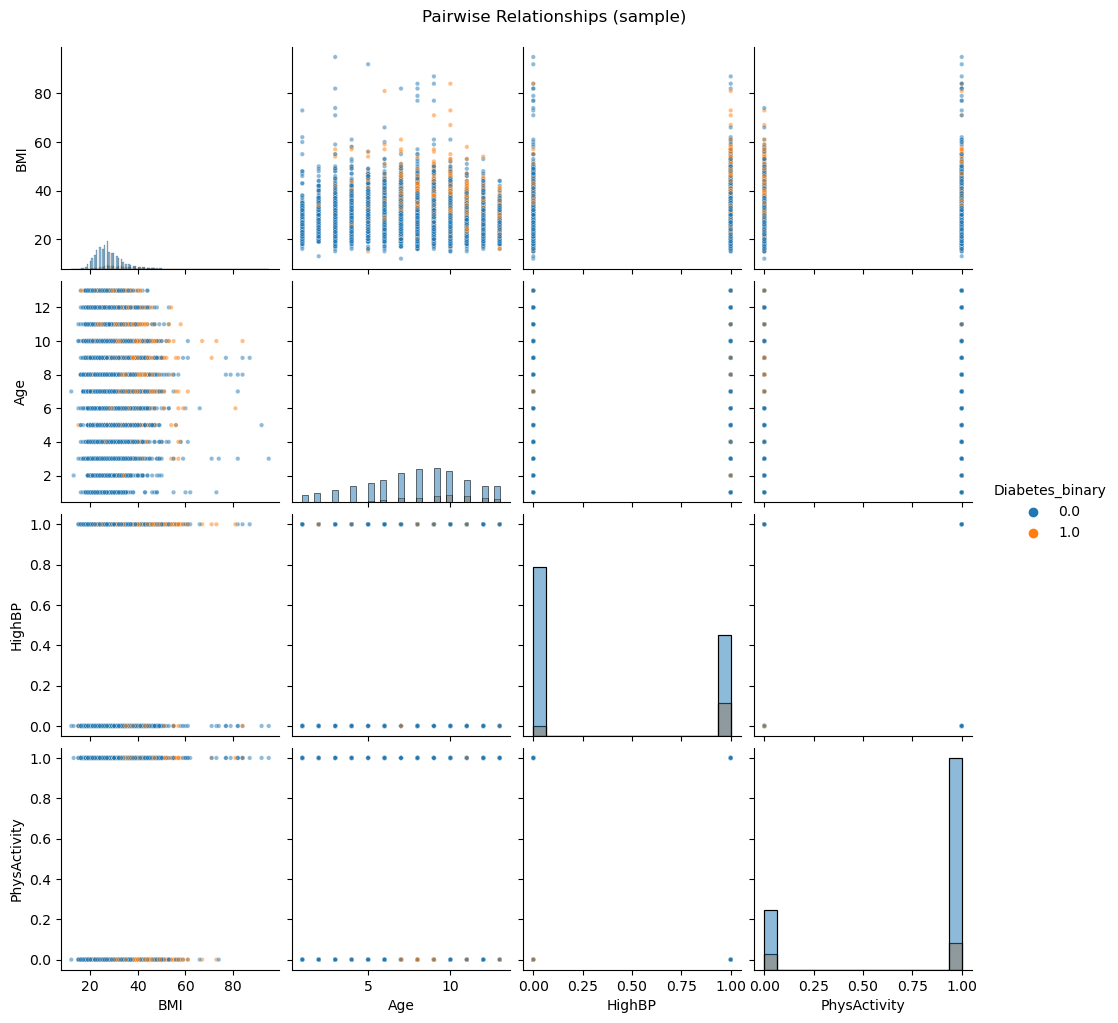

In [1]:
# 3.2 Exploratory Data Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the BRFSS 2015 diabetes binary health indicators dataset
df = pd.read_csv("diabetes_binary_health_indicators_BRFSS2015.csv")

# Define the three target (outcome) variables used in the modelling tasks
targets = ['Diabetes_binary', 'HeartDiseaseorAttack', 'Stroke']

# 1) Outcome prevalence (class imbalance)
# Create a row of 3 subplots, one for each target variable
fig, axes = plt.subplots(1, 3, figsize=(12, 3.8))

# Loop over each outcome and plot its class distribution (0 vs 1)
for ax, tgt in zip(axes, targets):
    # Countplot shows how many samples belong to each class (0/1)
    sns.countplot(x=tgt, data=df, ax=ax)
    # Compute the positive class rate (proportion of 1s)
    pos_rate = df[tgt].mean()
    # Add this rate to the title for quick reference
    ax.set_title(f"{tgt} (pos rate ≈ {pos_rate:.3f})")
    ax.set_xlabel("Class (0/1)")
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

# 2) BMI distribution by diabetes status 
plt.figure(figsize=(6.5, 4))
# Plot layered histograms of BMI split by Diabetes_binary (0 vs 1)
sns.histplot(
    data=df,
    x='BMI',
    hue='Diabetes_binary',  # separate curves/colours for diabetic vs non-diabetic
    kde=True,               # add kernel density estimate
    bins=40,
    element="step",         # step-style histogram outline
    stat="count"            # y-axis shows counts, not density
)
plt.title("BMI Distribution by Diabetes Status")
plt.xlabel("BMI")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 3) Age vs diabetes status 
plt.figure(figsize=(6.5, 4))
# Boxplot to show age distribution for each diabetes class without extreme outliers
sns.boxplot(x='Diabetes_binary', y='Age', data=df, showfliers=False)
# Add jittered individual points for more granular view (light dots)
sns.stripplot(
    x='Diabetes_binary',
    y='Age',
    data=df,
    size=1.2,
    alpha=0.2,
    color='black'
)
plt.title("Age vs Diabetes Status")
plt.xlabel("Diabetes_binary (0/1)")
plt.ylabel("Age (ordinal bands)")
plt.tight_layout()
plt.show()

#  4) Quick sanity checks for key predictors
# Select key predictors for visual inspection
key_preds = ['BMI', 'Age', 'HighBP', 'HighChol', 'PhysActivity', 'Smoker']

# Create a 2x3 grid of subplots to show each predictor
fig, axes = plt.subplots(2, 3, figsize=(12, 7))
axes = axes.ravel()  # flatten to 1D array for easy looping

for ax, col in zip(axes, key_preds):
    # If the variable has many unique values, treat as continuous and use histogram
    if df[col].nunique() > 10:
        sns.histplot(df[col], bins=40, kde=True, ax=ax)
        ax.set_title(f"{col} (nuniq={df[col].nunique()})")
    else:
        # Otherwise, treat as categorical and show a countplot
        sns.countplot(x=col, data=df, ax=ax)
        ax.set_title(f"{col} (categorical)")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

#  5) Pairwise glimpse for 4 most epidemiologically relevant variables 
# Choose a subset of variables for pairwise relationships
subset_cols = ['BMI', 'Age', 'HighBP', 'PhysActivity', 'Diabetes_binary']

# Sample up to 10,000 rows for faster plotting and better readability
sample_df = df[subset_cols].sample(n=min(10000, len(df)), random_state=42)

# Pairplot to visualise pairwise relationships, coloured by diabetes status
sns.pairplot(
    sample_df,
    hue='Diabetes_binary',
    plot_kws={'alpha': 0.5, 's': 10},  # lighter, smaller scatter points
    diag_kind='hist'                   # histograms on the diagonal
)

plt.suptitle("Pairwise Relationships (sample)", y=1.02)
plt.show()

In [2]:
# 3.2.1 Data Preprocessing & Integrity Check

import pandas as pd
import numpy as np

# Load the BRFSS 2015 diabetes indicators dataset
df = pd.read_csv("diabetes_binary_health_indicators_BRFSS2015.csv")

# Display dataset shape: expected to confirm ~253,680 rows and 22–24 columns
# (depending on original feature count version)
print(df.shape)  
# Display how many columns of each data type exist (e.g., int64, float64)
print(df.dtypes.value_counts())

# Basic Data Integrity Checks 
# Check for missing values across all columns.
# BRFSS public-release datasets should contain no missing values.
print("Missing values per column:\n", df.isna().sum().sort_values(ascending=False).head())

# Count approximate duplicate rows.
# Duplicate patterns are expected in BRFSS due to weighting and repeated population structures.
print("Approx. duplicate rows:", df.duplicated().sum())

# Descriptive statistics for continuous variables
# Evaluates basic distributional properties of BMI and Age.
print(df[['BMI', 'Age']].describe().T)

#  Confirm availability of outcome variables 
# Ensures that the 3 binary target columns exist.
targets = ['Diabetes_binary', 'HeartDiseaseorAttack', 'Stroke']
assert all(t in df.columns for t in targets), "Expected target columns not found."

# Identify predictor feature columns
# All columns except the targets are treated as predictors.
features = [c for c in df.columns if c not in targets]
print("Predictor count:", len(features))

(253680, 22)
float64    22
Name: count, dtype: int64
Missing values per column:
 Diabetes_binary    0
HighBP             0
Education          0
Age                0
Sex                0
dtype: int64
Approx. duplicate rows: 24206
        count       mean       std   min   25%   50%   75%   max
BMI  253680.0  28.382364  6.608694  12.0  24.0  27.0  31.0  98.0
Age  253680.0   8.032119  3.054220   1.0   6.0   8.0  10.0  13.0
Predictor count: 19


In [3]:
# 3.2.3 Train–Test Split and Feature Standardisation 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# --- Define base feature set (exclude outcome variables) ---
# All columns except the three outcome indicators are used as predictors.
base_feats = [c for c in df.columns if c not in ['Diabetes_binary',
                                                'HeartDiseaseorAttack',
                                                'Stroke']]

# Model 1: Diabetes outcome


# X_d: predictor matrix (all base features)
# y_d: binary target for diabetes status
X_d = df[base_feats].copy()
y_d = df['Diabetes_binary'].copy()

# Stratified 80/20 train–test split to preserve class proportions
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(
    X_d, y_d,
    test_size=0.2,
    random_state=42,    # ensures reproducibility
    stratify=y_d        # keeps same positive/negative ratio in both splits
)

# Standardise continuous predictors (BMI and Age) using z-scores.
# Fit scaler only on training data and apply the same transformation to test data
# to avoid information leakage.
scaler_d = StandardScaler()
X_train_d[['BMI', 'Age']] = scaler_d.fit_transform(X_train_d[['BMI', 'Age']])
X_test_d[['BMI', 'Age']]  = scaler_d.transform(X_test_d[['BMI', 'Age']])


# Model 2: Heart Disease / Attack


# For heart disease prediction, diabetes status is included as an additional predictor
X_hd = df[base_feats + ['Diabetes_binary']].copy()
y_hd = df['HeartDiseaseorAttack'].copy()

# Stratified 80/20 split for heart disease outcome
X_train_hd, X_test_hd, y_train_hd, y_test_hd = train_test_split(
    X_hd, y_hd,
    test_size=0.2,
    random_state=42,
    stratify=y_hd
)

# Standardise BMI and Age for the heart disease model
scaler_hd = StandardScaler()
X_train_hd[['BMI', 'Age']] = scaler_hd.fit_transform(X_train_hd[['BMI', 'Age']])
X_test_hd[['BMI', 'Age']]  = scaler_hd.transform(X_test_hd[['BMI', 'Age']])


# Model 3: Stroke


X_st = df[base_feats + ['Diabetes_binary']].copy()
y_st = df['Stroke'].copy()

# Stratified 80/20 split for stroke outcome
X_train_st, X_test_st, y_train_st, y_test_st = train_test_split(
    X_st, y_st,
    test_size=0.2,
    random_state=42,
    stratify=y_st
)

# Standardise BMI and Age for the stroke model
scaler_st = StandardScaler()
X_train_st[['BMI', 'Age']] = scaler_st.fit_transform(X_train_st[['BMI', 'Age']])
X_test_st[['BMI', 'Age']]  = scaler_st.transform(X_test_st[['BMI', 'Age']])

# Prints shapes of train/test matrices and prevalence (mean) of positive class
print("Diabetes:     ", X_train_d.shape, X_test_d.shape,
      y_train_d.mean().round(3), y_test_d.mean().round(3))
print("HeartDisease: ", X_train_hd.shape, X_test_hd.shape,
      y_train_hd.mean().round(3), y_test_hd.mean().round(3))
print("Stroke:       ", X_train_st.shape, X_test_st.shape,
      y_train_st.mean().round(3), y_test_st.mean().round(3))

Diabetes:      (202944, 19) (50736, 19) 0.139 0.139
HeartDisease:  (202944, 20) (50736, 20) 0.094 0.094
Stroke:        (202944, 20) (50736, 20) 0.041 0.041


In [4]:
# 3.2.4 Handling Class Imbalance with SMOTE

from imblearn.over_sampling import SMOTE

# SMOTE generates synthetic minority-class samples to reduce imbalance.
sm = SMOTE(random_state=42)

# Apply SMOTE only to TRAINING sets

# This is essential to avoid data leakage.

# --- Diabetes model ---
X_train_d_res, y_train_d_res = sm.fit_resample(X_train_d, y_train_d)

# --- Heart Disease model ---
X_train_hd_res, y_train_hd_res = sm.fit_resample(X_train_hd, y_train_hd)

# --- Stroke model ---
X_train_st_res, y_train_st_res = sm.fit_resample(X_train_st, y_train_st)

# Check class distribution after resampling

# value_counts(normalize=True) displays the proportion of each class.
# After SMOTE, both classes should appear in equal proportion (≈ 0.50 / 0.50).

print("Class balance after SMOTE (Diabetes):\n",
      y_train_d_res.value_counts(normalize=True))

print("Class balance after SMOTE (HeartDisease):\n",
      y_train_hd_res.value_counts(normalize=True))

print("Class balance after SMOTE (Stroke):\n",
      y_train_st_res.value_counts(normalize=True))

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/joblib/externals/loky/backend/context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/joblib/externals/loky/backend/context.py", line 217, in _count_physical_cores
    raise ValueError(


Class balance after SMOTE (Diabetes):
 Diabetes_binary
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64
Class balance after SMOTE (HeartDisease):
 HeartDiseaseorAttack
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64
Class balance after SMOTE (Stroke):
 Stroke
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64


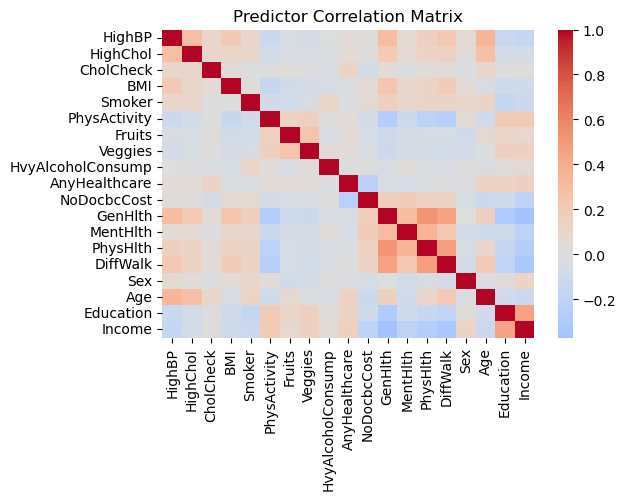

         Feature    VIF
11       GenHlth  1.765
13      PhysHlth  1.620
14      DiffWalk  1.520
18        Income  1.503
16           Age  1.327
17     Education  1.326
0         HighBP  1.324
12      MentHlth  1.238
1       HighChol  1.166
5   PhysActivity  1.156


In [5]:
#3.2.5 Multicollinearity and Correlation Analysis

import seaborn as sns
import matplotlib.pyplot as plt

# 1) Correlation Matrix for Predictor Variables

# The heatmap helps identify linear relationships between predictors.
# High correlations (e.g., > 0.8) can signal multicollinearity issues,
# which particularly affect models like Logistic Regression.

corr = df[base_feats].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Predictor Correlation Matrix")
plt.show()

# 2) Variance Inflation Factor (VIF) – Multicollinearity Diagnosis
# VIF quantifies how much a predictor is inflated by correlation with other predictors.
# VIF > 5 indicates moderate multicollinearity; VIF > 10 is considered problematic.
# We compute VIF using only the training set to avoid information leakage.

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Make a copy of training predictors for diabetes
X_vif = X_train_d.copy()

# statsmodels requires a constant column to compute VIF correctly
X_vif = X_vif.assign(constant=1.0)

# Compute VIF values for each predictor
vif = pd.DataFrame({
    "Feature": X_train_d.columns,
    "VIF": [
        variance_inflation_factor(X_vif.values, i)
        for i in range(X_train_d.shape[1])
    ]
}).sort_values("VIF", ascending=False)

# Round for improved readability
vif["VIF"] = vif["VIF"].round(3)

# Display the 10 predictors with highest VIF
print(vif.head(10))

In [6]:
# 3.3.2 Model Setup and Configuration

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# XGBoost may not be installed in all environments, so we check availability.
try:
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
except Exception as e:
    print("XGBoost not available, skipping XGB. Error:", e)
    XGB_AVAILABLE = False

RANDOM_STATE = 42  # ensures reproducibility across model runs


def build_models():
    """
    Instantiates the four supervised learning models used in the dissertation,
    each with parameters chosen for stability, fairness, and alignment with
    imbalanced health classification tasks.

    Logistic Regression → interpretable linear baseline  
    Decision Tree → simple non-linear model  
    Random Forest → ensemble bagging model for robustness  
    XGBoost → gradient boosting model optimised for tabular data

    Class weights are set to 'balanced' where supported to counteract class
    imbalance in the BRFSS dataset.
    """

    models = {

        # 1) Logistic Regression (baseline model)
        # L2-regularised logistic regression with class balancing.
        "Logistic Regression": LogisticRegression(
            solver="lbfgs",
            max_iter=500,
            penalty="l2",
            class_weight="balanced",
            random_state=RANDOM_STATE,
            n_jobs=None  # LR is computationally light
        ),

        # 2) Decision Tree
        # A simple non-linear classifier with Gini impurity.
        # Class weighting mitigates imbalance across outcomes.
        "Decision Tree": DecisionTreeClassifier(
            criterion="gini",
            class_weight="balanced",
            random_state=RANDOM_STATE
        ),

        # 3) Random Forest
        # An ensemble of 200 decision trees using bootstrap sampling.
        # Provides strong out-of-the-box performance on structured data.
        "Random Forest": RandomForestClassifier(
            n_estimators=200,
            class_weight="balanced",
            random_state=RANDOM_STATE,
            n_jobs=-1  # parallel processing
        )
    }
    # 4) XGBoost (only added if installed)

    if XGB_AVAILABLE:
        models["XGBoost"] = XGBClassifier(
            # Core parameters
            n_estimators=300,
            learning_rate=0.1,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,

            # Class imbalance handling
            scale_pos_weight=3,   # accounts for minority class underrepresentation

            # Stability and optimisation
            eval_metric="logloss",
            random_state=RANDOM_STATE,
            n_jobs=-1
        )

    return models


# Instantiate the models and print summary to confirm correct setup
models = build_models()
print("Models configured:")
for name, m in models.items():
    print(f" - {name}: {m.__class__.__name__}")

Models configured:
 - Logistic Regression: LogisticRegression
 - Decision Tree: DecisionTreeClassifier
 - Random Forest: RandomForestClassifier
 - XGBoost: XGBClassifier


In [7]:
#3.3.3 Cross-Validation Framework

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, cross_validate
import numpy as np, pandas as pd

def quick_cv_table(X_res, y_res, models_dict, n_sub=0.3, n_splits=3, seed=42):
    """
    Performs a lightweight model comparison using a stratified subsample
    of the resampled training data and 3-fold Stratified K-Fold CV.

    Why this approach is used:
    - Extremely large datasets (e.g., BRFSS) make full CV computationally heavy.
    - StratifiedShuffleSplit preserves class balance in the subsample.
    - ROC-AUC and PR-AUC provide robust ranking for imbalanced data.
    - Allows quick, fair comparison across models before full training.

    """
    # 1) Create a stratified subsample to reduce CV computation time
    sss = StratifiedShuffleSplit(
        n_splits=1,
        test_size=(1 - n_sub),
        random_state=seed
    )
    sub_idx, _ = next(sss.split(X_res, y_res))

    X_sub = X_res.iloc[sub_idx]
    y_sub = y_res.iloc[sub_idx]

  
    # 2) Define 3-fold Stratified K-Fold CV
   
    cv = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=seed
    )

    # 3) Evaluate each model using ROC-AUC and PR-AUC

    rows = []
    for name, model in models_dict.items():
        out = cross_validate(
            model,
            X_sub,
            y_sub,
            scoring=["roc_auc", "average_precision"],
            cv=cv,
            n_jobs=-1,            # parallel computation
            return_train_score=False
        )
        rows.append({
            "Model": name,
            "Mean ROC-AUC": np.mean(out["test_roc_auc"]),
            "Mean PR-AUC":  np.mean(out["test_average_precision"])
        })

    # Sort by PR-AUC (most relevant metric for imbalance)
    tbl = pd.DataFrame(rows).sort_values(
        ["Mean PR-AUC", "Mean ROC-AUC"],
        ascending=False
    ).reset_index(drop=True)

    return tbl


# Run CV ranking for the three prediction tasks
fast_d  = quick_cv_table(X_train_d_res,  y_train_d_res,  models, n_sub=0.3)
fast_hd = quick_cv_table(X_train_hd_res, y_train_hd_res, models, n_sub=0.3)
fast_st = quick_cv_table(X_train_st_res, y_train_st_res, models, n_sub=0.3)

print("CV — Diabetes");       display(fast_d)
print("CV — Heart Disease");  display(fast_hd)
print("CV — Stroke");         display(fast_st)

# Select top-2 performing models per task for full evaluation
finalists = {
    "Diabetes":       list(fast_d["Model"].head(2)),
    "Heart Disease":  list(fast_hd["Model"].head(2)),
    "Stroke":         list(fast_st["Model"].head(2))
}

finalists

CV — Diabetes


,Model,Mean ROC-AUC,Mean PR-AUC
0,XGBoost,0.969301,0.975817
1,Random Forest,0.963197,0.967215
2,Decision Tree,0.852605,0.800236
3,Logistic Regression,0.834012,0.800130


CV — Heart Disease


,Model,Mean ROC-AUC,Mean PR-AUC
0,XGBoost,0.980916,0.985094
1,Random Forest,0.979851,0.982144
2,Decision Tree,0.889936,0.846874
3,Logistic Regression,0.854565,0.825674


CV — Stroke


,Model,Mean ROC-AUC,Mean PR-AUC
0,Random Forest,0.994131,0.995162
1,XGBoost,0.990670,0.993082
2,Decision Tree,0.938652,0.910838
3,Logistic Regression,0.825589,0.790776


{'Diabetes': ['XGBoost', 'Random Forest'],
 'Heart Disease': ['XGBoost', 'Random Forest'],
 'Stroke': ['Random Forest', 'XGBoost']}

In [8]:
#  3.3.4 Step 1 — Setup and helper functions 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, brier_score_loss,
    confusion_matrix
)
from sklearn.calibration import CalibrationDisplay

# --- helper: safe probability getter ---
def _get_proba(estimator, X):
    if hasattr(estimator, "predict_proba"):
        return estimator.predict_proba(X)[:, 1]
    if hasattr(estimator, "decision_function"):
        s = estimator.decision_function(X)
        return 1 / (1 + np.exp(-s))
    raise ValueError("No probability method found.")

# --- helper: evaluate one model on test set ---
def evaluate_on_test(name, estimator, X_train_res, y_train_res, X_test, y_test,
                     plot_confusion=True, plot_calibration=True):
    estimator.fit(X_train_res, y_train_res)
    y_pred = estimator.predict(X_test)
    y_prob = _get_proba(estimator, X_test)

    metrics = {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1": f1_score(y_test, y_pred, zero_division=0),
        "ROC-AUC": roc_auc_score(y_test, y_prob),
        "PR-AUC": average_precision_score(y_test, y_prob),
        "Brier": brier_score_loss(y_test, np.clip(y_prob, 1e-6, 1-1e-6)),
    }

    if plot_confusion:
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(4,3.2))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.title(f"{name} — Confusion Matrix")
        plt.xlabel("Predicted"); plt.ylabel("Actual")
        plt.tight_layout(); plt.show()

    if plot_calibration:
        fig, ax = plt.subplots(figsize=(4,3.2))
        CalibrationDisplay.from_predictions(y_test, y_prob, n_bins=10, strategy="uniform", ax=ax)
        ax.set_title(f"{name} — Calibration Curve")
        plt.tight_layout(); plt.show()

    return metrics

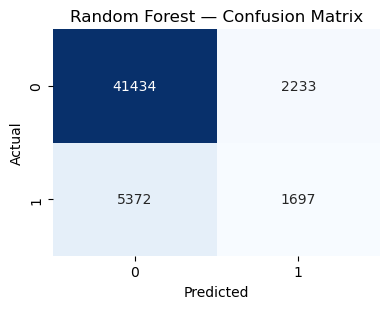

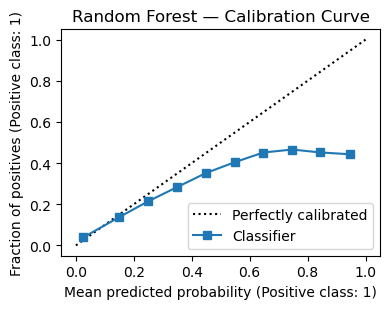

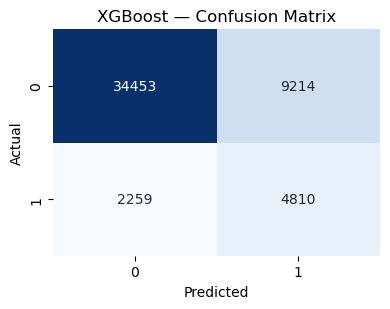

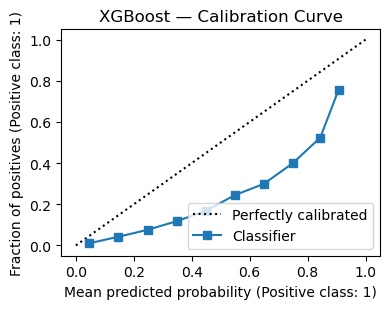

,Model,Accuracy,Precision,Recall,F1,ROC-AUC,PR-AUC,Brier
1,XGBoost,0.773869,0.342983,0.680436,0.456075,0.819339,0.409383,0.146835
0,Random Forest,0.850106,0.431807,0.240062,0.308574,0.793644,0.350718,0.107773


In [9]:
#  3.3.4 Step 2A — Evaluate finalists on DIABETES
"""
This section evaluates the top-performing models identified during the
cross-validation screening stage (Step 2).  
For the diabetes prediction task, the two strongest candidates were:

    • Random Forest
    • XGBoost

Both models are rebuilt here with stable, task-appropriate hyperparameters
and then assessed on the untouched test set using the unified evaluation
function from Step 1.
"""

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


# Finalist models for Diabetes prediction

finalists_diabetes = {
    "Random Forest": RandomForestClassifier(
        n_estimators=150,           # moderately large ensemble for stability
        class_weight="balanced",    # internal correction for class imbalance
        random_state=42,
        n_jobs=1                    # single-core for reproducibility
    ),

    "XGBoost": XGBClassifier(
        eval_metric="logloss",      # required objective for binary classification
        random_state=42,
        n_estimators=200,           # stronger boosting (200 rounds)
        learning_rate=0.1,          # standard learning rate for tabular data
        max_depth=4,                # restrict depth to avoid overfitting
        subsample=0.8,              # row sampling to increase generalisation
        colsample_bytree=0.8,       # column sampling per tree
        scale_pos_weight=3,         # additional imbalance handling
        n_jobs=1
    )
}

# Evaluate each finalist model using the test set

diabetes_rows = []

for name, est in finalists_diabetes.items():
    """
    For each model:
        1. Train on SMOTE-balanced training data
        2. Evaluate on the original, untouched test data
        3. Produce:
            - full metric report (Accuracy, Precision, Recall, F1)
            - ROC-AUC + PR-AUC (important for imbalance)
            - Brier score (probability calibration)
            - Confusion matrix plot
            - Calibration curve plot
    """
    metrics = evaluate_on_test(
        name, est,
        X_train_d_res, y_train_d_res,   # balanced training data
        X_test_d, y_test_d,             # real distribution test data
        plot_confusion=True,
        plot_calibration=True
    )
    diabetes_rows.append(metrics)

# Create sorted comparison table for reporting

diabetes_results = (
    pd.DataFrame(diabetes_rows)[
        ["Model","Accuracy","Precision","Recall","F1","ROC-AUC","PR-AUC","Brier"]
    ]
    # sort primarily by PR-AUC (important for imbalanced data),
    # then ROC-AUC, then F1-score
    .sort_values(["PR-AUC","ROC-AUC","F1"], ascending=False)
)

display(diabetes_results)

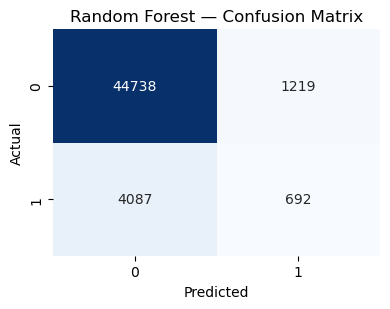

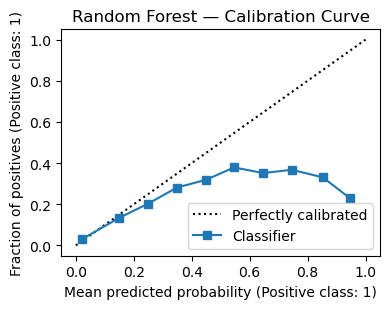

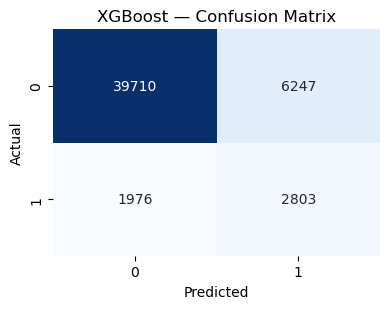

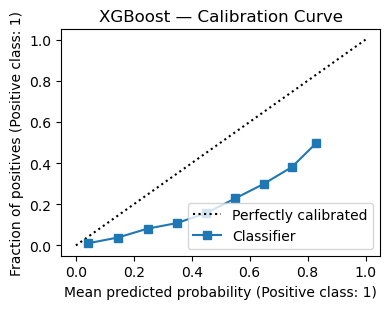

,Model,Accuracy,Precision,Recall,F1,ROC-AUC,PR-AUC,Brier
1,XGBoost,0.837926,0.309724,0.586524,0.405380,0.835980,0.333758,0.109187
0,Random Forest,0.895419,0.362114,0.144800,0.206876,0.809396,0.274469,0.079317


In [10]:
# 3.3.4 Step 2B — Evaluate finalists on HEART DISEASE
finalists_hd = {
    "Random Forest": RandomForestClassifier(
        n_estimators=150, class_weight="balanced",
        random_state=42, n_jobs=1
    ),
    "XGBoost": XGBClassifier(
        eval_metric="logloss", random_state=42,
        n_estimators=200, learning_rate=0.1, max_depth=4,
        subsample=0.8, colsample_bytree=0.8, scale_pos_weight=3,
        n_jobs=1
    )
}

hd_rows = []
for name, est in finalists_hd.items():
    m = evaluate_on_test(
        name, est,
        X_train_hd_res, y_train_hd_res,
        X_test_hd, y_test_hd,
        plot_confusion=True, plot_calibration=True
    )
    hd_rows.append(m)

hd_results = pd.DataFrame(hd_rows)[
    ["Model","Accuracy","Precision","Recall","F1","ROC-AUC","PR-AUC","Brier"]
].sort_values(["PR-AUC","ROC-AUC","F1"], ascending=False)

display(hd_results)

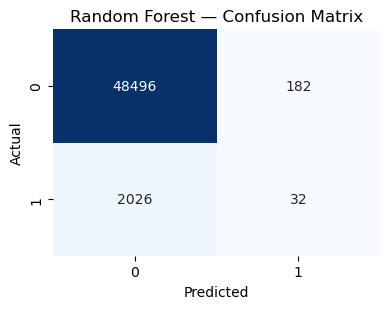

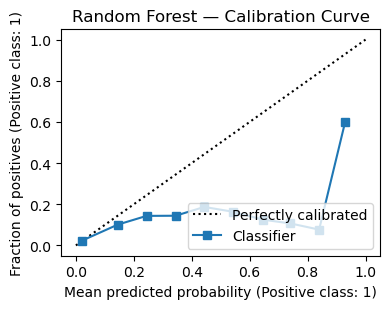

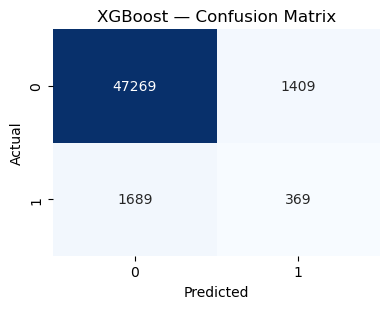

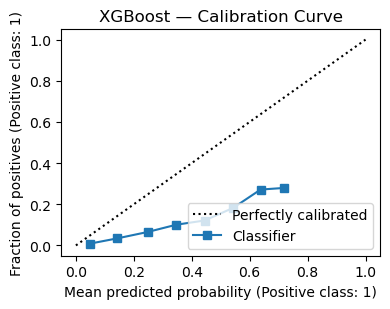

,Model,Accuracy,Precision,Recall,F1,ROC-AUC,PR-AUC,Brier
1,XGBoost,0.938939,0.207537,0.179300,0.192388,0.797437,0.145346,0.058790
0,Random Forest,0.956481,0.149533,0.015549,0.028169,0.771624,0.115163,0.039777


In [11]:
# ===== 3.3.4 Step 2C — Evaluate finalists on STROKE =====
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

finalists_stroke = {
    "Random Forest": RandomForestClassifier(
        n_estimators=150, class_weight="balanced",
        random_state=42, n_jobs=1
    ),
    "XGBoost": XGBClassifier(
        eval_metric="logloss", random_state=42,
        n_estimators=200, learning_rate=0.1, max_depth=4,
        subsample=0.8, colsample_bytree=0.8, scale_pos_weight=3,
        n_jobs=1
    )
}

stroke_rows = []
for name, est in finalists_stroke.items():
    m = evaluate_on_test(
        name, est,
        X_train_st_res, y_train_st_res,
        X_test_st, y_test_st,
        plot_confusion=True, plot_calibration=True
    )
    stroke_rows.append(m)

stroke_results = pd.DataFrame(stroke_rows)[
    ["Model","Accuracy","Precision","Recall","F1","ROC-AUC","PR-AUC","Brier"]
].sort_values(["PR-AUC","ROC-AUC","F1"], ascending=False)

display(stroke_results)

Random Forest — Top 10 Features (Diabetes)


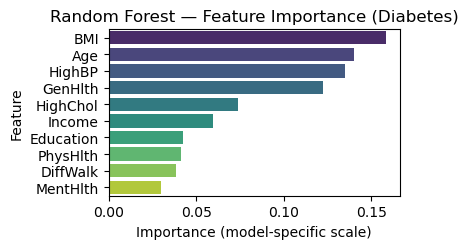

XGBoost — Top 10 Features (Diabetes)


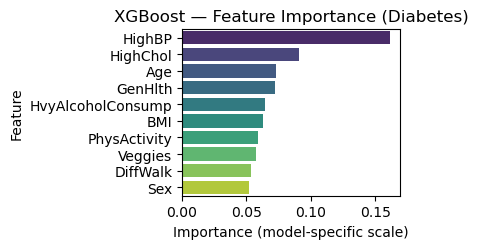

In [12]:
# 3.3.5 Step 1 — Feature Importance for XGBoost and Random Forest 
"""
This section extracts and visualises global feature importance for the two
ensemble models (Random Forest and XGBoost). Feature-importance analysis
helps identify which behavioural and clinical risk factors contribute most
strongly to model predictions.

For demonstration, the diabetes model is used as the representative task,
since the same methodology applies to heart disease and stroke.
"""

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier


# Helper function: plot the top N most important features

def plot_feature_importance(model, X_train, title, top_n=10):
    """
    Trains the given model on the resampled training set (diabetes task)
    and plots the top N features ranked by importance.

    • Random Forest uses Gini impurity reduction as its importance metric.
    • XGBoost uses gain-based importance (improvement in model loss).
    • Both measures provide global (model-level) explanations.
    """
    # Fit the model on SMOTE-balanced diabetes training data
    model.fit(X_train, y_train_d_res)

    # Build a sortable importance table
    importances = pd.DataFrame({
        "Feature": X_train.columns,
        "Importance": model.feature_importances_
    }).sort_values("Importance", ascending=False).head(top_n)

    # Visualisation
    plt.figure(figsize=(4.2, 2.6))
    sns.barplot(
        data=importances,
        x="Importance", y="Feature",
        palette="viridis"
    )
    plt.title(title)
    plt.xlabel("Importance (model-specific scale)")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()


# Define model configurations consistent with the final evaluation stage

rf = RandomForestClassifier(
    n_estimators=150,
    class_weight="balanced",    # mitigate imbalance effects
    random_state=42,
    n_jobs=1
)

xgb = XGBClassifier(
    eval_metric="logloss",      # stable objective for binary classification
    random_state=42,
    n_estimators=200,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=3,         # additional imbalance handling
    n_jobs=1
)


# Produce feature-importance visualisations

print("Random Forest — Top 10 Features (Diabetes)")
plot_feature_importance(
    rf, X_train_d_res,
    title="Random Forest — Feature Importance (Diabetes)"
)

print("XGBoost — Top 10 Features (Diabetes)")
plot_feature_importance(
    xgb, X_train_d_res,
    title="XGBoost — Feature Importance (Diabetes)"
)

Random Forest — Top 10 Features (Heart Disease)


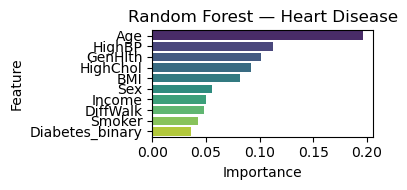

XGBoost — Top 10 Features (Heart Disease)


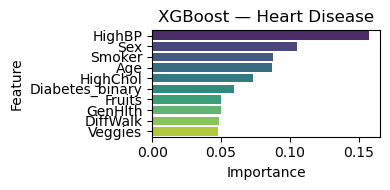

Random Forest — Top 10 Features (Stroke)


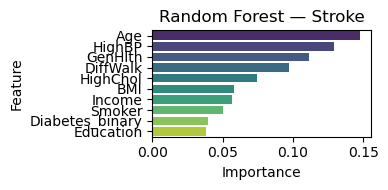

XGBoost — Top 10 Features (Stroke)


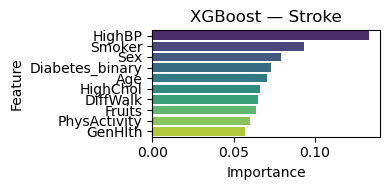

In [13]:
# ===== 3.3.5 — Feature Importance for Heart Disease & Stroke =====
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

def plot_feature_importance(model, X_train, y_train, title, top_n=10):
    model.fit(X_train, y_train)
    importances = pd.DataFrame({
        "Feature": X_train.columns,
        "Importance": model.feature_importances_
    }).sort_values("Importance", ascending=False).head(top_n)

    plt.figure(figsize=(4, 2))
    sns.barplot(data=importances, x="Importance", y="Feature", palette="viridis")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# --- Heart Disease ---
rf_hd = RandomForestClassifier(
    n_estimators=150, class_weight="balanced",
    random_state=42, n_jobs=1
)
xgb_hd = XGBClassifier(
    eval_metric="logloss", random_state=42,
    n_estimators=200, learning_rate=0.1, max_depth=4,
    subsample=0.8, colsample_bytree=0.8, scale_pos_weight=3,
    n_jobs=1
)

print("Random Forest — Top 10 Features (Heart Disease)")
plot_feature_importance(rf_hd, X_train_hd_res, y_train_hd_res, "Random Forest — Heart Disease")

print("XGBoost — Top 10 Features (Heart Disease)")
plot_feature_importance(xgb_hd, X_train_hd_res, y_train_hd_res, "XGBoost — Heart Disease")

# --- Stroke ---
rf_st = RandomForestClassifier(
    n_estimators=150, class_weight="balanced",
    random_state=42, n_jobs=1
)
xgb_st = XGBClassifier(
    eval_metric="logloss", random_state=42,
    n_estimators=200, learning_rate=0.1, max_depth=4,
    subsample=0.8, colsample_bytree=0.8, scale_pos_weight=3,
    n_jobs=1
)

print("Random Forest — Top 10 Features (Stroke)")
plot_feature_importance(rf_st, X_train_st_res, y_train_st_res, "Random Forest — Stroke")

print("XGBoost — Top 10 Features (Stroke)")
plot_feature_importance(xgb_st, X_train_st_res, y_train_st_res, "XGBoost — Stroke")

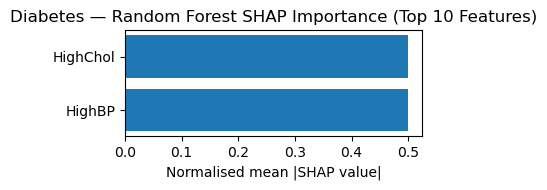

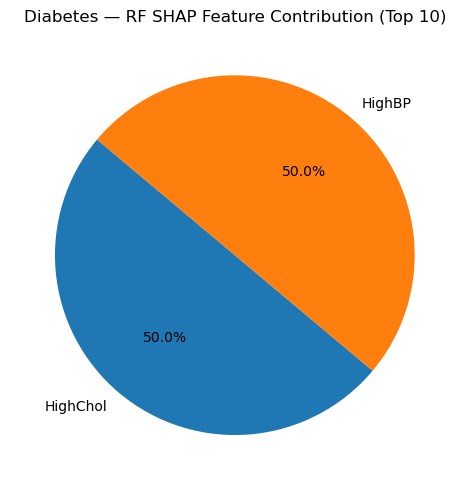

In [14]:

# 3.3.6 — SHAP Explainability Analysis 

"""
This block computes SHAP (SHapley Additive exPlanations) values for a
lightweight Random Forest model trained on the SMOTE-balanced diabetes data.

"""

import shap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier



# 1. Fit a lightweight Random Forest model

"""
We use a smaller Random Forest (fewer estimators, limited depth) to keep
SHAP computation tractable. T
"""

rf_small = RandomForestClassifier(
    n_estimators=80,         # fewer trees for speed
    max_depth=8,            # restrict tree depth to reduce SHAP cost
    min_samples_leaf=20,    # regularisation for smoother splits
    class_weight="balanced",
    random_state=42,
    n_jobs=1
)

rf_small.fit(X_train_d_res, y_train_d_res)


# 2. Subsample the test set for SHAP evaluation

"""
SHAP values scale poorly with dataset size. Sampling 200 instances is enough
"""

X_small = X_test_d.sample(200, random_state=42)



# 3. Compute SHAP values using TreeExplainer

"""
TreeExplainer efficiently computes exact Shapley values for tree-based
models. For binary classification, shap_values returns a list of two
arrays: index 1 corresponds to the positive class (diabetes = 1).
"""

explainer = shap.TreeExplainer(rf_small)
shap_values = explainer.shap_values(X_small)

# Extract SHAP values for the positive class
sv = shap_values[1]

# Fix edge-case where SHAP adds an extra bias column
if sv.shape[1] == X_small.shape[1] + 1:
    sv = sv[:, :-1]


# 4. Compute mean absolute SHAP values for each feature

"""
Mean |SHAP| values quantify each feature’s average contribution magnitude.
"""

shap_abs = np.abs(sv).mean(axis=0)
feature_names = np.array(X_small.columns)

# Extract top 10 contributing features
top_k = 10
idx = np.argsort(shap_abs)[::-1][:top_k]

top_importances = shap_abs[idx]
top_features = feature_names[idx]

# Optional normalisation for plotting clarity
top_importances = top_importances / top_importances.sum()

# Convert labels to plain strings (avoids matplotlib issues)
labels = [str(f) for f in top_features]
values = top_importances


# 5. Visualisation — SHAP Bar Chart (Top 10 Features)

"""
A horizontal bar chart communicates relative feature contributions.
"""

plt.figure(figsize=(4, 2))
plt.barh(labels[::-1], values[::-1])  # reverse for descending order
plt.xlabel("Normalised mean |SHAP value|")
plt.title("Diabetes — Random Forest SHAP Importance (Top 10 Features)")
plt.tight_layout()
plt.show()


# 6. Visualisation — Optional SHAP Pie Chart
"""
A pie chart illustrates approximate proportional contribution of the
top features. 
"""

plt.figure(figsize=(5, 5))
plt.pie(
    values,
    labels=labels,
    autopct="%1.1f%%",
    startangle=140
)
plt.title("Diabetes — RF SHAP Feature Contribution (Top 10)")
plt.tight_layout()
plt.show()

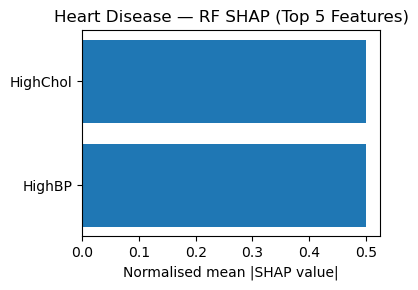

In [15]:

# 4. — SHAP Analysis for Heart Disease (Random Forest)

"""
This block computes SHAP (SHapley Additive exPlanations) values for a
Random Forest classifier trained on the SMOTE-balanced heart disease data.
It follows the same design as the diabetes SHAP analysis to keep the
pipeline consistent across outcomes.
"""

import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.ensemble import RandomForestClassifier


# Helper: mean absolute SHAP values (positive class)

def mean_abs_shap_posclass(explainer, X):
    """
    Compute mean absolute SHAP values for the positive class.

    Handles different output formats returned by TreeExplainer:
    - list of arrays [class0, class1]
    - 3D array (n_classes, n_samples, n_features)
    and removes any extra bias column if present.
    """
    sv = explainer.shap_values(X)

    # Case 1: SHAP returns a list [shap_class0, shap_class1]
    if isinstance(sv, list):
        sv = sv[1]  # select positive class (class=1)

    # Case 2: ensure numpy array (may be 2D or 3D)
    sv = np.asarray(sv)
    if sv.ndim == 3:        # shape = (n_classes, n_samples, n_features)
        sv = sv[1, :, :]    # select positive class → (n_samples, n_features)

    # Some SHAP versions prepend an extra bias column → drop if present
    if sv.shape[1] == X.shape[1] + 1:
        sv = sv[:, :-1]

    # Mean absolute SHAP per feature across all samples
    shap_abs = np.abs(sv).mean(axis=0)
    return shap_abs

# 1) HEART DISEASE — SHAP
# =========================
"""
We train a lightweight Random Forest on the SMOTE-balanced
heart disease training data to keep SHAP computations tractable.
"""

rf_hd_small = RandomForestClassifier(
    n_estimators=80,        # fewer trees → faster SHAP computation
    max_depth=8,           # restrict depth to reduce complexity
    min_samples_leaf=20,   # regularisation for smoother splits
    class_weight="balanced",
    random_state=42,
    n_jobs=1
)

rf_hd_small.fit(X_train_hd_res, y_train_hd_res)

# Subsample the test set to reduce SHAP runtime (max 200 rows)
X_small_hd = X_test_hd.sample(min(200, len(X_test_hd)), random_state=42)

# Build SHAP TreeExplainer and compute mean |SHAP| per feature
explainer_hd = shap.TreeExplainer(rf_hd_small)
shap_abs_hd = mean_abs_shap_posclass(explainer_hd, X_small_hd)


# Select top-k most important features
# -----------------------------
feat_names_hd = np.array(X_small_hd.columns)
k_hd = min(5, len(feat_names_hd))  # top 5 for concise plot

# Indices of features sorted by importance (descending)
idx_hd = np.argsort(shap_abs_hd)[::-1][:k_hd]

top_vals_hd = shap_abs_hd[idx_hd]
# Normalise so values sum to 1 (easier to interpret visually)
top_vals_hd = top_vals_hd / top_vals_hd.sum()
top_names_hd = feat_names_hd[idx_hd]


# Plot: Horizontal bar chart
# -----------------------------
plt.figure(figsize=(4, 3))
labels_hd = [str(x) for x in top_names_hd[::-1]]  # reverse for descending order
y_pos_hd = np.arange(len(labels_hd))

plt.barh(y_pos_hd, top_vals_hd[::-1])
plt.yticks(y_pos_hd, labels_hd)
plt.xlabel("Normalised mean |SHAP value|")
plt.title("Heart Disease — RF SHAP (Top 5 Features)")
plt.tight_layout()
plt.show()

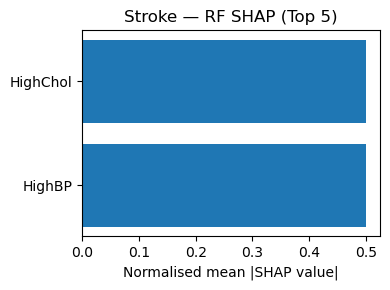

In [16]:

# 2) STROKE — SHAP

rf_st_small = RandomForestClassifier(
    n_estimators=80,
    max_depth=8,
    min_samples_leaf=20,
    class_weight="balanced",
    random_state=42,
    n_jobs=1
)
rf_st_small.fit(X_train_st_res, y_train_st_res)

X_small_st = X_test_st.sample(min(200, len(X_test_st)), random_state=42)

explainer_st = shap.TreeExplainer(rf_st_small)
shap_abs_st = mean_abs_shap_posclass(explainer_st, X_small_st)

feat_names_st = np.array(X_small_st.columns)
k_st = min(5, len(feat_names_st))
idx_st = np.argsort(shap_abs_st)[::-1][:k_st]

top_vals_st = shap_abs_st[idx_st]
top_vals_st = top_vals_st / top_vals_st.sum()
top_names_st = feat_names_st[idx_st]

plt.figure(figsize=(4, 3))
labels_st = [str(x) for x in top_names_st[::-1]]
y_pos_st = np.arange(len(labels_st))
plt.barh(y_pos_st, top_vals_st[::-1])
plt.yticks(y_pos_st, labels_st)
plt.xlabel("Normalised mean |SHAP value|")
plt.title("Stroke — RF SHAP (Top 5)")
plt.tight_layout()
plt.show()